In [1]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
!pip install catboost
from catboost import CatBoostClassifier,CatBoostRegressor

     |████████████████████████████████| 62.9MB 116kB/s 


## Import necessary python libraries for EDA

In [0]:
import pandas as pd
import numpy as np
np.random.seed(643)
import matplotlib.pyplot as plt

# Load csv file from my google drive account

There is a public folder in my google drive account wherein i have stored student csv file. Shareable link for downloading it from there is https://drive.google.com/open?id=14NPp9XNtTuoWxv_jEFMkwl3Eatl5hvtq . <br>
one can see this file just by clicking on the above link and can import into google colaboratory after authentication.

In [0]:
# import csv file from google drive via Pydrive
! pip install -U -q PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# Authenticate and create pydrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:

# now we'll use shareable link to import csv file
s_link = 'https://drive.google.com/open?id=14NPp9XNtTuoWxv_jEFMkwl3Eatl5hvtq'
# we need only id portion of the shareable link
flush,id_portion = s_link.split('=')
print(id_portion)

14NPp9XNtTuoWxv_jEFMkwl3Eatl5hvtq


In [0]:
download = drive.CreateFile({'id':id_portion})

In [0]:
download.GetContentFile('student-por.csv')

In [9]:
df = pd.read_csv('student-por.csv',sep=';')
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13


In [10]:
df.count()

school        649
sex           649
age           649
address       649
famsize       649
Pstatus       649
Medu          649
Fedu          649
Mjob          649
Fjob          649
reason        649
guardian      649
traveltime    649
studytime     649
failures      649
schoolsup     649
famsup        649
paid          649
activities    649
nursery       649
higher        649
internet      649
romantic      649
famrel        649
freetime      649
goout         649
Dalc          649
Walc          649
health        649
absences      649
G1            649
G2            649
G3            649
dtype: int64

There are no missing values in this dataset.
All attributes have same 649 samples.

In [0]:
from collections import Counter

In [12]:
for i in df.columns:
  print(i,':',(Counter(df[i]).items()))

school : dict_items([('GP', 423), ('MS', 226)])
sex : dict_items([('F', 383), ('M', 266)])
age : dict_items([(18, 140), (17, 179), (15, 112), (16, 177), (19, 32), (22, 1), (20, 6), (21, 2)])
address : dict_items([('U', 452), ('R', 197)])
famsize : dict_items([('GT3', 457), ('LE3', 192)])
Pstatus : dict_items([('A', 80), ('T', 569)])
Medu : dict_items([(4, 175), (1, 143), (3, 139), (2, 186), (0, 6)])
Fedu : dict_items([(4, 128), (1, 174), (2, 209), (3, 131), (0, 7)])
Mjob : dict_items([('at_home', 135), ('health', 48), ('other', 258), ('services', 136), ('teacher', 72)])
Fjob : dict_items([('teacher', 36), ('other', 367), ('services', 181), ('health', 23), ('at_home', 42)])
reason : dict_items([('course', 285), ('other', 72), ('home', 149), ('reputation', 143)])
guardian : dict_items([('mother', 455), ('father', 153), ('other', 41)])
traveltime : dict_items([(2, 213), (1, 366), (3, 54), (4, 16)])
studytime : dict_items([(2, 305), (3, 97), (1, 212), (4, 35)])
failures : dict_items([(0, 5

It seems that attributes like absenses, G1, G2 and G3 are not categorical. since they have numerical values we will keep them as they are and covert all the text values(categorical values) in each attributes into numerics because machine learning algorithms use/understand some sort of numerical values.

In [0]:
# Make a copy of original dataframe so that original one may be required later.
df_c = df

In [14]:
df_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
school        649 non-null object
sex           649 non-null object
age           649 non-null int64
address       649 non-null object
famsize       649 non-null object
Pstatus       649 non-null object
Medu          649 non-null int64
Fedu          649 non-null int64
Mjob          649 non-null object
Fjob          649 non-null object
reason        649 non-null object
guardian      649 non-null object
traveltime    649 non-null int64
studytime     649 non-null int64
failures      649 non-null int64
schoolsup     649 non-null object
famsup        649 non-null object
paid          649 non-null object
activities    649 non-null object
nursery       649 non-null object
higher        649 non-null object
internet      649 non-null object
romantic      649 non-null object
famrel        649 non-null int64
freetime      649 non-null int64
goout         649 non-null int64
Dalc          649 no

In [15]:
a = Counter(df_c['Mjob'])
print(a)
list(dict(a).keys())

Counter({'other': 258, 'services': 136, 'at_home': 135, 'teacher': 72, 'health': 48})


['at_home', 'health', 'other', 'services', 'teacher']

we will create a function that will convert all the categories in each attribute(attribute having categorical values) into whole numbers.

In [0]:
# categorical attribute having text values
cat_features = ['school', 'sex', 'address', 'famsize','Pstatus',
       'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic']

In [17]:
# this is dataframe containing attribues having categorical values(string/text values) that needs to be converted in numbers
df_c[cat_features].head()

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
0,GP,F,U,GT3,A,at_home,teacher,course,mother,yes,no,no,no,yes,yes,no,no
1,GP,F,U,GT3,T,at_home,other,course,father,no,yes,no,no,no,yes,yes,no
2,GP,F,U,LE3,T,at_home,other,other,mother,yes,no,no,no,yes,yes,yes,no
3,GP,F,U,GT3,T,health,services,home,mother,no,yes,no,yes,yes,yes,yes,yes
4,GP,F,U,GT3,T,other,other,home,father,no,yes,no,no,yes,yes,no,no


In [0]:
# Below small piece of code will convert the text values into numerics in each categoriacal attribute
for i in cat_features:
  df_c[i].replace(list(dict(Counter(df_c[i])).keys()),[j for j in range(len(dict(Counter(df_c[i])).keys()))], inplace=True)

In [19]:
df_c.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,0,18,0,0,0,4,4,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,4,3,4,1,1,3,4,0,11,11
1,0,0,17,0,0,1,1,1,0,1,0,1,1,2,0,1,1,0,0,1,0,1,0,5,3,3,1,1,3,2,9,11,11
2,0,0,15,0,1,1,1,1,0,1,1,0,1,2,0,0,0,0,0,0,0,1,0,4,3,2,2,3,3,6,12,13,12
3,0,0,15,0,0,1,4,2,1,2,2,0,1,3,0,1,1,0,1,0,0,1,1,3,2,2,1,1,5,0,14,14,14
4,0,0,16,0,0,1,3,3,2,1,2,1,1,2,0,1,1,0,0,0,0,0,0,4,3,2,1,2,5,0,11,13,13


Our data is now ready and can be feeded as input to the machine learning algorithm

## Binary Classification
Now let's see how many students passed and how many of them failed. <br>
criteria:- <br>
if G3>=10 then pass else fail

In [0]:

def converto(x):
  if x < 10:
    return 0
  else:
    return 1

def convert2(x):
  
  if x>=16:
    return 1
  elif x>=14 and x<16:
    return 2
  elif x>=12 and x<14:
    return 3
  elif x>=10 and x<12:
    return 4
  else:
    return 5

In [21]:
X = df_c
Y = df_c.G3.apply(converto)
# Preprocessing the data
scaled_data =  StandardScaler().fit(X).transform(X)

# create an instance of catboost model
model =  CatBoostClassifier()

# divide the dataset in training set and testing set
X_train, X_test, Y_train, Y_test = train_test_split(scaled_data,Y,test_size=.3)

# train your model using train set
model.fit(X_train,Y_train)


# test your model using test set
y_pred = model.predict(X_test)
print('training accuracy',model.score(X_train,Y_train))
print('testing accuracy',model.score(X_test,Y_test))

Learning rate set to 0.013399
0:	learn: 0.6623930	total: 52.1ms	remaining: 52.1s
1:	learn: 0.6316818	total: 56.1ms	remaining: 28s
2:	learn: 0.6055241	total: 59.7ms	remaining: 19.8s
3:	learn: 0.5806115	total: 63.6ms	remaining: 15.8s
4:	learn: 0.5574081	total: 67.7ms	remaining: 13.5s
5:	learn: 0.5281527	total: 70.2ms	remaining: 11.6s
6:	learn: 0.5039817	total: 74.1ms	remaining: 10.5s
7:	learn: 0.4793266	total: 78.3ms	remaining: 9.71s
8:	learn: 0.4613238	total: 82ms	remaining: 9.03s
9:	learn: 0.4416146	total: 85.8ms	remaining: 8.5s
10:	learn: 0.4247775	total: 89.5ms	remaining: 8.05s
11:	learn: 0.4026261	total: 92.4ms	remaining: 7.61s
12:	learn: 0.3818076	total: 96.3ms	remaining: 7.31s
13:	learn: 0.3667364	total: 100ms	remaining: 7.04s
14:	learn: 0.3522610	total: 104ms	remaining: 6.81s
15:	learn: 0.3353099	total: 107ms	remaining: 6.59s
16:	learn: 0.3214784	total: 111ms	remaining: 6.42s
17:	learn: 0.3091400	total: 115ms	remaining: 6.25s
18:	learn: 0.2970578	total: 119ms	remaining: 6.12s
19:

In [22]:
print(list(Y[:10]),list(y_pred[:10]))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1] [1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0]


In [23]:
df_c.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,0,18,0,0,0,4,4,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,4,3,4,1,1,3,4,0,11,11
1,0,0,17,0,0,1,1,1,0,1,0,1,1,2,0,1,1,0,0,1,0,1,0,5,3,3,1,1,3,2,9,11,11
2,0,0,15,0,1,1,1,1,0,1,1,0,1,2,0,0,0,0,0,0,0,1,0,4,3,2,2,3,3,6,12,13,12
3,0,0,15,0,0,1,4,2,1,2,2,0,1,3,0,1,1,0,1,0,0,1,1,3,2,2,1,1,5,0,14,14,14
4,0,0,16,0,0,1,3,3,2,1,2,1,1,2,0,1,1,0,0,0,0,0,0,4,3,2,1,2,5,0,11,13,13


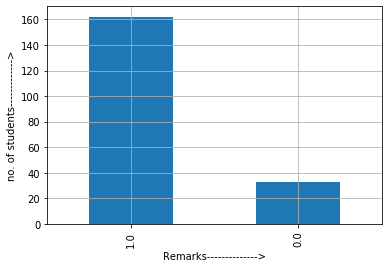

In [29]:
plt.xlabel('Remarks-------------->')
plt.ylabel('no. of students------------->')
pd.Series(y_pred).value_counts().plot(kind='bar') # binary classification on test set.
plt.grid(True)
plt.show()

In [31]:
X.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

# 5-Level Classification
<table>
  <tr>
    <th>Group</th>
    <th>Marks</th>
    <th>Remarks</th>
  </tr>

  <tr>
    <td>1</td>
    <td>16-20</td>
    <td>Excellent</td>
  </tr>

  <tr>
    <td>2</td>
    <td>14-15</td>
    <td>Good</td>
  </tr>

  <tr>
    <td>3</td>
    <td>12-13</td>
    <td>Satisfactory</td>
  </tr>

  <tr>
    <td>4</td>
    <td>10-11</td>
    <td>Sufficient</td>
  </tr>

  <tr>
    <td>5</td>
    <td>0-9</td>
    <td>Fail</td>
  </tr>

</table>

In [45]:
X.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,0,18,0,0,0,4,4,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,4,3,4,1,1,3,4,0,11,11
1,0,0,17,0,0,1,1,1,0,1,0,1,1,2,0,1,1,0,0,1,0,1,0,5,3,3,1,1,3,2,9,11,11
2,0,0,15,0,1,1,1,1,0,1,1,0,1,2,0,0,0,0,0,0,0,1,0,4,3,2,2,3,3,6,12,13,12
3,0,0,15,0,0,1,4,2,1,2,2,0,1,3,0,1,1,0,1,0,0,1,1,3,2,2,1,1,5,0,14,14,14
4,0,0,16,0,0,1,3,3,2,1,2,1,1,2,0,1,1,0,0,0,0,0,0,4,3,2,1,2,5,0,11,13,13


In [76]:
X = df_c
Y = df_c.G3.apply(convert2)
# Preprocessing the data
scaled_data =  StandardScaler().fit(X).transform(X)

# create an instance of catboost model
model =  CatBoostClassifier()

# divide the dataset in training set and testing set
X_train, X_test, Y_train, Y_test = train_test_split(scaled_data,Y,test_size=.3)

# train your model using train set
model.fit(X_train,Y_train)


# test your model using test set
y_pred = model.predict(X_test)
print('training accuracy',model.score(X_train,Y_train))
print('testing accuracy',model.score(X_test,Y_test))

0:	learn: 1.5305251	total: 4.72ms	remaining: 4.71s
1:	learn: 1.4631178	total: 9.3ms	remaining: 4.64s
2:	learn: 1.4044906	total: 13.3ms	remaining: 4.43s
3:	learn: 1.3408864	total: 17.3ms	remaining: 4.31s
4:	learn: 1.2854049	total: 20.9ms	remaining: 4.16s
5:	learn: 1.2300670	total: 24.7ms	remaining: 4.09s
6:	learn: 1.1865983	total: 28.8ms	remaining: 4.08s
7:	learn: 1.1380298	total: 35.4ms	remaining: 4.38s
8:	learn: 1.0920366	total: 39.3ms	remaining: 4.33s
9:	learn: 1.0690991	total: 43.4ms	remaining: 4.3s
10:	learn: 1.0223152	total: 47.6ms	remaining: 4.28s
11:	learn: 0.9808261	total: 51.4ms	remaining: 4.24s
12:	learn: 0.9393560	total: 55.5ms	remaining: 4.21s
13:	learn: 0.9100151	total: 59.8ms	remaining: 4.21s
14:	learn: 0.8767098	total: 64.2ms	remaining: 4.22s
15:	learn: 0.8424670	total: 69.1ms	remaining: 4.25s
16:	learn: 0.8137985	total: 74.1ms	remaining: 4.28s
17:	learn: 0.7903794	total: 78.2ms	remaining: 4.26s
18:	learn: 0.7619255	total: 82.5ms	remaining: 4.26s
19:	learn: 0.7410768	tot

In [89]:
r = pd.DataFrame(y_pred)
r[0].value_counts()

4.0    65
3.0    47
2.0    35
5.0    26
1.0    22
Name: 0, dtype: int64

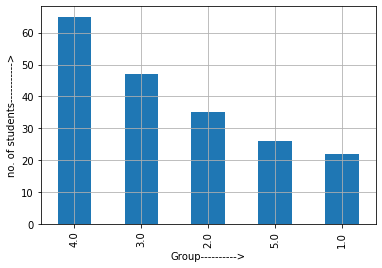

In [90]:

pd.Series(r[0]).value_counts().plot(kind='bar')
plt.xlabel('Group---------->')
plt.ylabel('no. of students----------->')
plt.grid(True)
plt.show()

# Regression

In [91]:
4
#Y = df_c.pop('G3')
X = df_c
# Preprocessing the data
scaled_data =  StandardScaler().fit(X).transform(X)

# create an instance of catboost model
model =  CatBoostRegressor(iterations=500)

# divide the dataset in training set and testing set
X_train, X_test, Y_train, Y_test = train_test_split(scaled_data,Y,test_size=.2)

# train your model using train set
model.fit(X_train,Y_train)

y_pred = model.predict(X_test)

0:	learn: 1.2344933	total: 1.72ms	remaining: 857ms
1:	learn: 1.2049052	total: 3.33ms	remaining: 831ms
2:	learn: 1.1754968	total: 4.69ms	remaining: 778ms
3:	learn: 1.1486603	total: 6.09ms	remaining: 755ms
4:	learn: 1.1228058	total: 7.55ms	remaining: 747ms
5:	learn: 1.0989245	total: 8.87ms	remaining: 731ms
6:	learn: 1.0756888	total: 10.2ms	remaining: 721ms
7:	learn: 1.0501305	total: 11.6ms	remaining: 715ms
8:	learn: 1.0265773	total: 13ms	remaining: 710ms
9:	learn: 1.0018302	total: 14.4ms	remaining: 707ms
10:	learn: 0.9772661	total: 15.8ms	remaining: 702ms
11:	learn: 0.9565292	total: 17.1ms	remaining: 696ms
12:	learn: 0.9330449	total: 19.7ms	remaining: 736ms
13:	learn: 0.9104320	total: 21.1ms	remaining: 732ms
14:	learn: 0.8893505	total: 22.5ms	remaining: 729ms
15:	learn: 0.8686789	total: 23.9ms	remaining: 723ms
16:	learn: 0.8474845	total: 25.3ms	remaining: 719ms
17:	learn: 0.8292214	total: 26.7ms	remaining: 715ms
18:	learn: 0.8101340	total: 28.4ms	remaining: 719ms
19:	learn: 0.7943854	tot

In [0]:
print(r2_score(Y_test,y_pred))

0.9979658604319094


In [0]:
np.sqrt(mean_squared_error(Y_test,y_pred))

0.05728196571002629

In [0]:
"""# feature importance
x,y =[],[]
#etc.fit(X_train,Y_train)
f = list(zip(X.columns,model.feature_importances_))
k  = lambda s: s[1]
f = sorted(f,key=k,reverse=True)
for i,j in f:
  y.append(i)
  x.append(j)

# plot graph
plt.figure(figsize=(12,6))
plt.title("feature Importance")
plt.xlabel("Relative Importance")
plt.ylabel("Features")
plt.barh(y,x,height=.8,color='g')

plt.show()"""

'# feature importance\nx,y =[],[]\n#etc.fit(X_train,Y_train)\nf = list(zip(X.columns,model.feature_importances_))\nk  = lambda s: s[1]\nf = sorted(f,key=k,reverse=True)\nfor i,j in f:\n  y.append(i)\n  x.append(j)\n\n# plot graph\nplt.figure(figsize=(12,6))\nplt.title("feature Importance")\nplt.xlabel("Relative Importance")\nplt.ylabel("Features")\nplt.barh(y,x,height=.8,color=\'g\')\n\nplt.show()'

# Thank you 
Any query:-<br>
Email id: hbr8218@gmail.com